In [ ]:
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          6.3                         
year           2020                        
month          02                          
day            29                          
svn rev        77875                       
language       R                           
version.string R version 3.6.3 (2020-02-29)
nickname       Holding the Windsock        

For this project, we will be using packagen lme4 and nlme in R and package statsmodels in python to evaluate the important causes that contribute to PM2.5 in Beijing, China. Due to the skewness of PM2.5 against variable “cbwd”, we choose to do a log transformation on the response variable. The way we pick out the best model to fit is by plotting log(PM2.5) against every predictor in different wind directions. We also have summarized and compared our result in the conclusion.

In [11]:
library(dplyr)
library(ggplot2)
library(MASS)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




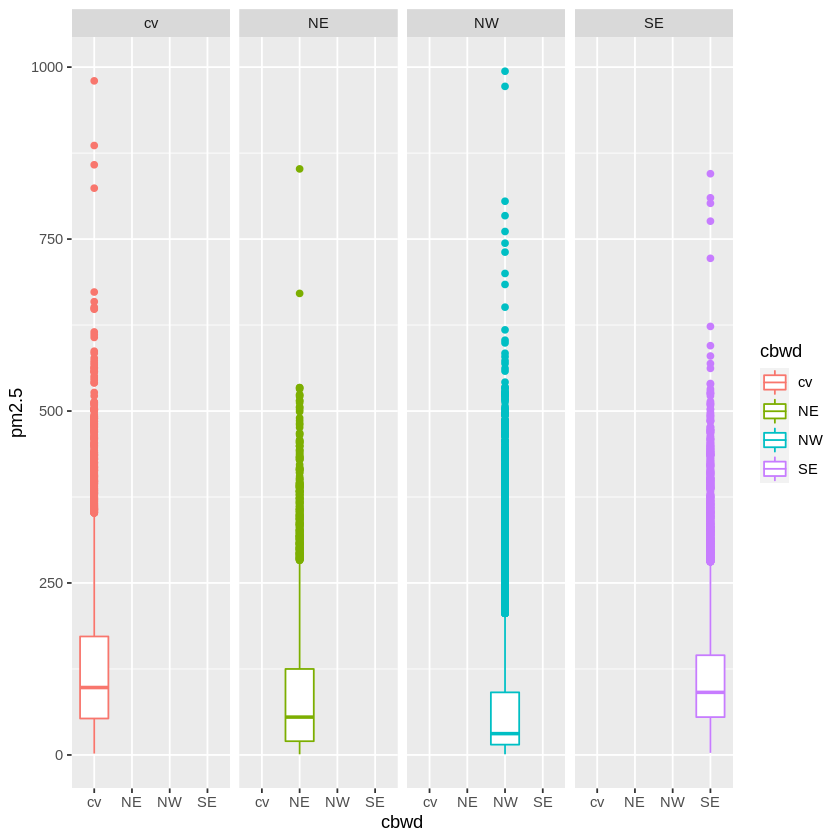

In [7]:
AQ=read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv")
# divide the months into four seasons
seasons = c( 'winter',
             'winter',
             rep('spring',3),
             rep('summer',3),
             rep('fall',3),
             'winter'
)
# delete the mising values
AQ = AQ %>%
  filter(!is.na(pm2.5) & pm2.5 > 0) %>%
  mutate(season=factor(month, 1:12, seasons)) 
# boxplot for response grouped by cbwd
qplot(cbwd, pm2.5, facets = . ~ cbwd, 
      colour = cbwd, geom = "boxplot", data = AQ)

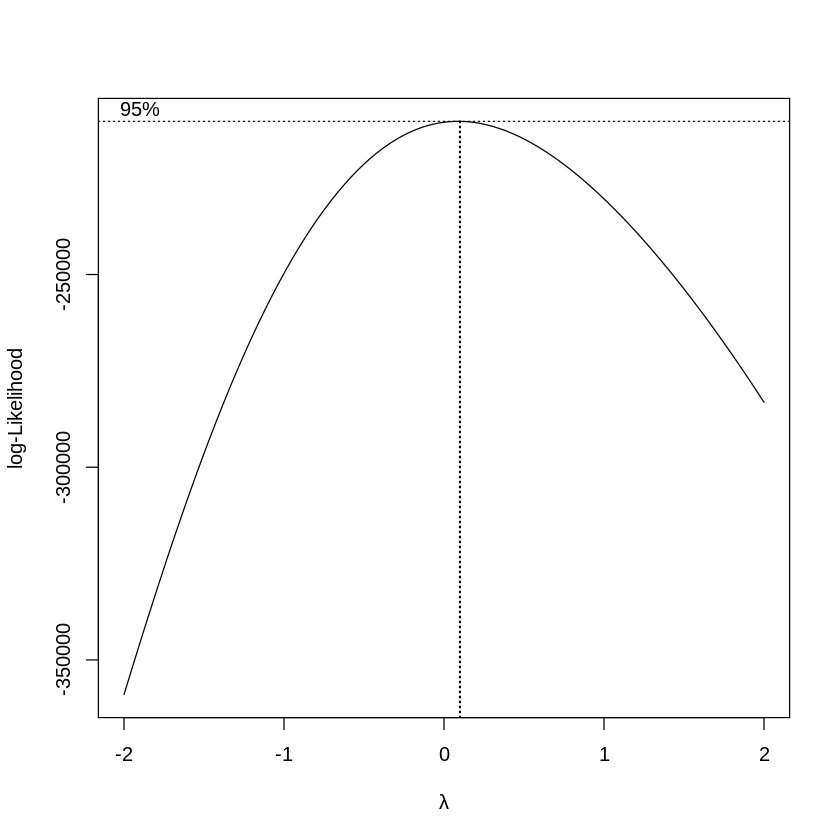

In [12]:
# draw the box-cox plot
g =lm(pm2.5~., data = AQ)
boxcox(g,plotit=T)

In [13]:
# the plot a log transformation for the response 
AQ=
  AQ%>%
  mutate(pm2.5_log=log(pm2.5)) %>%
  filter(is.finite(pm2.5_log))

The Box-Cox plot suggests a log transformation for the response variable. We then drop the outliers and draw the boxplot for response grouped by the variable cbwd.

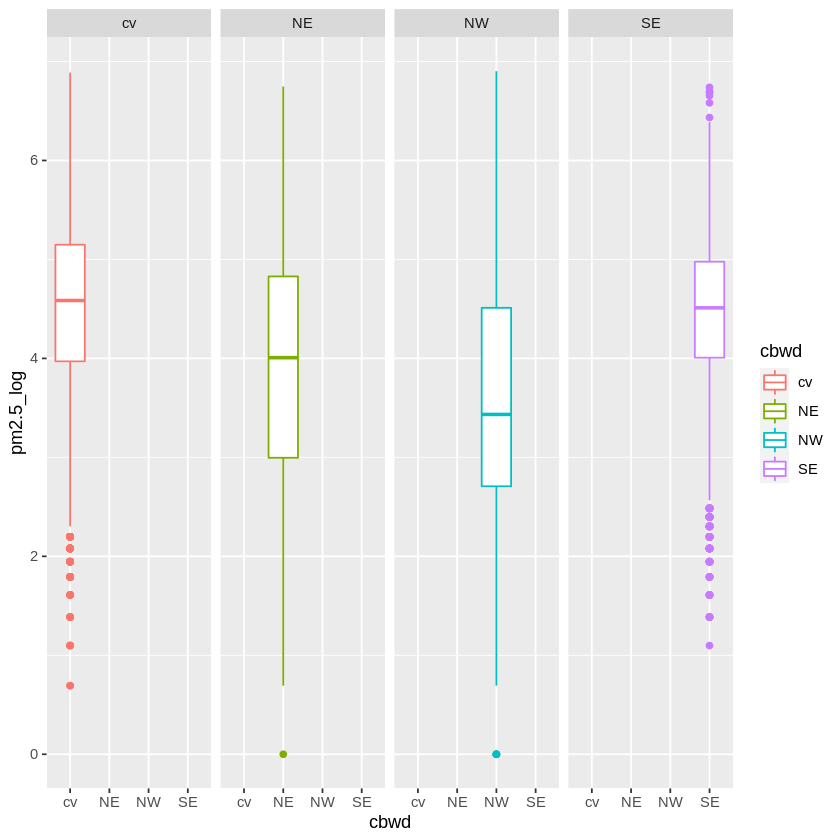

In [15]:
qplot(cbwd, pm2.5_log, facets = . ~ cbwd, 
      colour = cbwd, geom = "boxplot", data = AQ)

In [17]:
install.packages("lme4")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘minqa’, ‘nloptr’, ‘statmod’, ‘RcppEigen’




In [19]:
library(lme4)
res = lmer(pm2.5_log ~ year+month+day+hour+DEWP+TEMP+PRES+Is+Ir+(1+hour+PRES|cbwd), 
           REML = TRUE,
           data = AQ)
summary(res)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 2 negative eigenvalues”


Linear mixed model fit by REML ['lmerMod']
Formula: pm2.5_log ~ year + month + day + hour + DEWP + TEMP + PRES +  
    Is + Ir + (1 + hour + PRES | cbwd)
   Data: AQ

REML criterion at convergence: 99360.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3629 -0.6620  0.0250  0.6879  4.1619 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr       
 cbwd     (Intercept) 1.368e+01 3.698839            
          hour        1.821e-05 0.004268 -0.22      
          PRES        2.860e+00 1.691186 -0.06 -0.60
 Residual             6.294e-01 0.793363            
Number of obs: 41755, groups:  cbwd, 4

Fixed effects:
              Estimate Std. Error  t value
(Intercept) 38.1438545  5.8933346    6.472
year        -0.0067990  0.0027689   -2.456
month       -0.0225851  0.0012034  -18.768
day          0.0064249  0.0004428   14.510
hour         0.0126715  0.0022287    5.686
DEWP         0.0615840  0.0005576  110.438
TEMP        -0.0795696  0.0007107 -111.959
PRES       

Since the smooth line looks flat, the residuals and fitted values seems to be irrelevant.Then we test whether random effects are warranted:

In [22]:
resb = lm(pm2.5_log ~ year+month+day+hour+DEWP+TEMP+PRES+Is+Ir, data = AQ)
dev1 = -2*logLik(res);dev0 = -2*logLik(resb)
devdiff = as.numeric(dev0-dev1)
dfdiff <- attr(dev1,"df")-attr(dev0,"df"); dfdiff

[1] 6

In [23]:
cat('Chi-square =', devdiff, '(df=', dfdiff,'), p =', 
    pchisq(devdiff,dfdiff,lower.tail=FALSE))

Chi-square = 4689.412 (df= 6 ), p = 0

In [24]:
BIC(resb, res) # compare the BIC of simple linear regression and linear mixed model

,df,BIC
,<dbl>,<dbl>
resb,11,104166.83
res,17,99541.25


In [29]:
install.packages("nlme")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [30]:
library(nlme)
resc=lme(pm2.5_log ~ year+month+day+hour+DEWP+TEMP+PRES+Is+Ir, random=~1+hour+PRES|cbwd,  
            method = 'ML', data = AQ)
summary(resc)


Attaching package: ‘nlme’


The following object is masked from ‘package:lme4’:

    lmList


The following object is masked from ‘package:dplyr’:

    collapse




Linear mixed-effects model fit by maximum likelihood
  Data: AQ 
       AIC      BIC    logLik
  99580.66 99727.53 -49773.33

Random effects:
 Formula: ~1 + hour + PRES | cbwd
 Structure: General positive-definite, Log-Cholesky parametrization
            StdDev       Corr        
(Intercept) 8.843154e-07 (Intr) hour 
hour        4.088123e-03 0.171       
PRES        2.610174e-04 0.905  0.536
Residual    7.966436e-01             

Fixed effects:  pm2.5_log ~ year + month + day + hour + DEWP + TEMP + PRES +      Is + Ir 
               Value Std.Error    DF    t-value p-value
(Intercept) 35.43778  5.609096 41742    6.31791  0.0000
year        -0.00500  0.002778 41742   -1.80021  0.0718
month       -0.02228  0.001207 41742  -18.45560  0.0000
day          0.00635  0.000445 41742   14.27481  0.0000
hour         0.01311  0.002144 41742    6.11494  0.0000
DEWP         0.06165  0.000559 41742  110.25449  0.0000
TEMP        -0.08007  0.000713 41742 -112.34553  0.0000
PRES        -0.02013  0.00

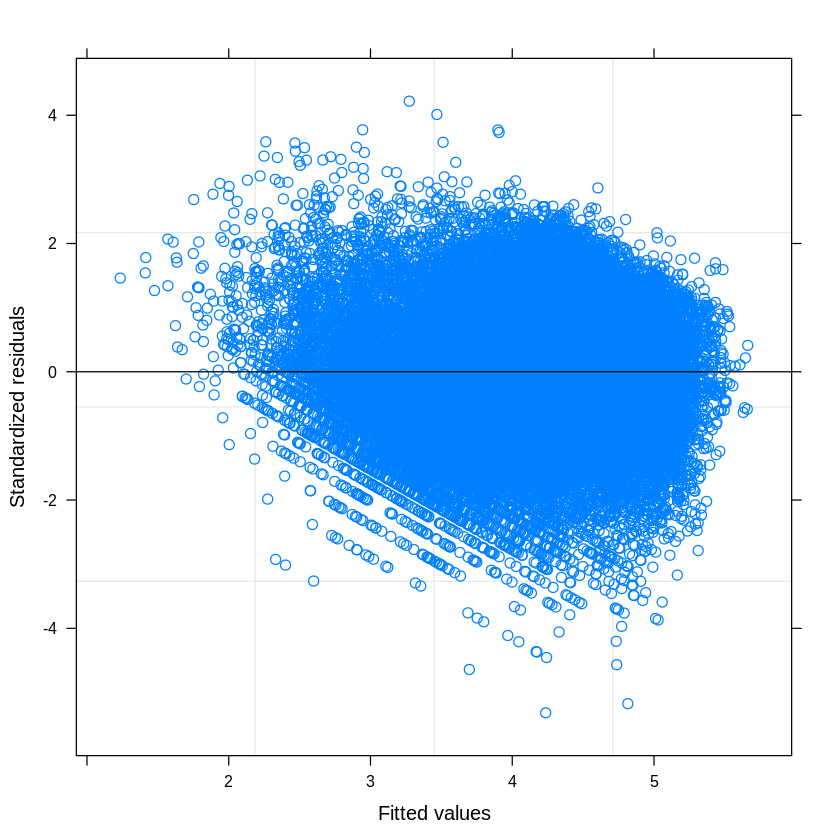

In [31]:
# plot the residuals vs. fitted values plot
plot(resc)

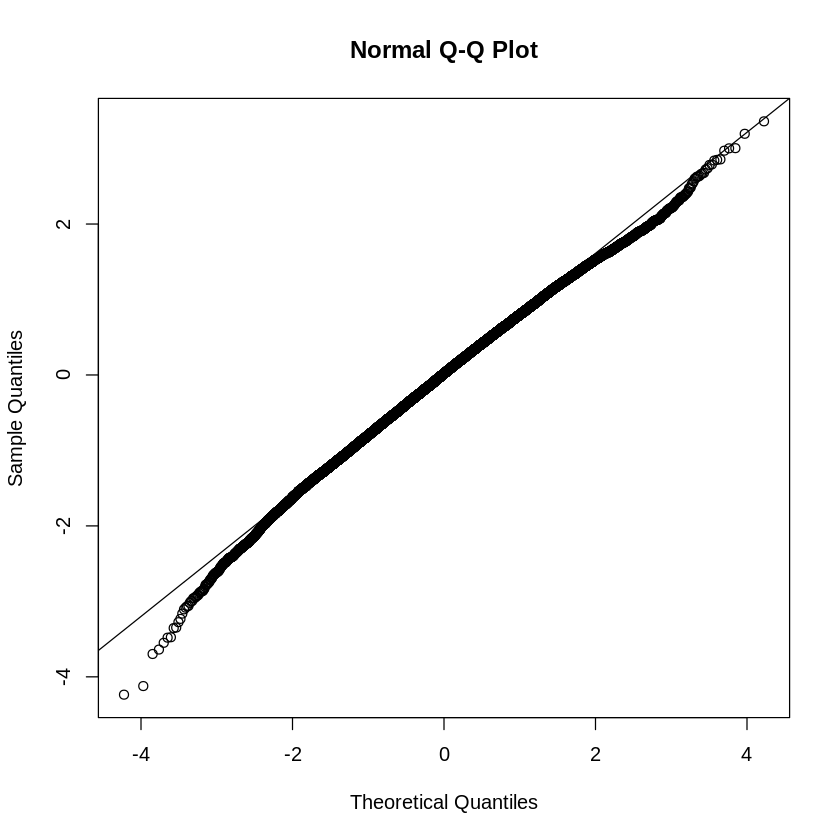

In [32]:
# plot qqplot
qqnorm(resid(resc))
qqline(resid(resc))

In [34]:
install.packages("stargazer")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [35]:
library(stargazer)
stargazer(resc, type = "text",
          digits = 3,
          star.cutoffs = c(0.05, 0.01, 0.001),
          digit.separator = "")


Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 





                         Dependent variable:     
                    -----------------------------
                              pm2.5_log          
-------------------------------------------------
year                           -0.005            
                               (0.003)           
                                                 
month                         -0.022***          
                               (0.001)           
                                                 
day                           0.006***           
                              (0.0004)           
                                                 
hour                          0.013***           
                               (0.002)           
                                                 
DEWP                          0.062***           
                               (0.001)           
                                                 
TEMP                          -0.080***          

In [36]:
BIC(res, resc)

,df,BIC
,<dbl>,<dbl>
res,17,99541.25
resc,17,99727.53
